# Final Project - Medical Diagnosis Clustering Based on Symptoms

### Importing and cleaning data

In [100]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("aai530-group6/ddxplus")

Using custom data configuration ddxplus-648e998559240fad
Reusing dataset csv (C:\Users\noopys\.cache\huggingface\datasets\csv\ddxplus-648e998559240fad\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


In [101]:
import pandas as pd
#Dataset has 1 million rows. We will focus on the first 10,000
#Load into dataframe
diagnosis = dataset['train'].select(range(10000))
df=pd.DataFrame(diagnosis)
#Get rid of column that displays results of ML algo this dataset was originally used for
df = df.drop("DIFFERENTIAL_DIAGNOSIS", axis=1)
df.head()

#Checking how many unique elements there are
import ast
df['EVIDENCES'] = df['EVIDENCES'].apply(ast.literal_eval)

#Initialize a set to hold unique elements across all rows
unique_elements = set()

for row in df.itertuples():
    # Using update to add elements from each list in the EVIDENCES column
    unique_elements.update(row.EVIDENCES)
#print(unique_elements)

In [102]:
for evidence in unique_elements:
    df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
    
#Now we can drop column that holds all of the evidences bc we have them in seperate binary columns
df = df.drop('EVIDENCES', axis=1)
df.head()

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)
C:\Users\noopys\AppData\Local\Temp\ipykernel_10120\1060347745.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[evidence] = df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0)


,AGE,SEX,PATHOLOGY,INITIAL_EVIDENCE,E_133_@_V_32,E_55_@_V_63,E_141,E_133_@_V_35,E_132_@_4,E_89,...,E_54_@_V_154,E_134_@_3,E_56_@_10,E_96,E_133_@_V_194,E_57_@_V_30,E_57_@_V_170,E_55_@_V_187,E_57_@_V_159,E_134_@_7
0,49,F,GERD,E_201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,M,Bronchitis,E_53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,49,M,Acute dystonic reactions,E_128,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,64,M,Acute laryngitis,E_53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,70,F,URTI,E_201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K - Means Algorithm 

In [103]:
import numpy as np
#Hamming distance here 
def distance(a, b):
    return np.mean(a!=b)
    
def k_modes(df_binary, k, max_iter=100):
    # Randomly initialize the cluster centers
    initial_clusters = df_binary.sample(n=k).values
    cluster_assignments = np.zeros(df_binary.shape[0], dtype=int)

    for iteration in range(max_iter):
        # Initialize an empty list to store new cluster centers
        new_clusters = [np.zeros(df_binary.shape[1]) for _ in range(k)]
        cluster_sizes = [0] * k

        # Assign each point to the nearest cluster
        for i, row in df_binary.iterrows():
            dissimilarities = [distance(row.values, cluster) for cluster in initial_clusters]
            closest_cluster = np.argmin(dissimilarities)
            cluster_assignments[i] = closest_cluster
            new_clusters[closest_cluster] += row.values
            cluster_sizes[closest_cluster] += 1

        # Update cluster centers
        for j in range(k):
            if cluster_sizes[j] > 0:
                new_clusters[j] /= cluster_sizes[j]
                new_clusters[j] = np.round(new_clusters[j])  # Convert to binary format

        # Check for convergence (if clusters did not change)
        if np.array_equal(initial_clusters, new_clusters):
            break

        initial_clusters = new_clusters

    return cluster_assignments

In [120]:
# Identify binary columns
binary_columns = [col for col in df.columns if df[col].nunique() == 2 and df[col].dropna().isin([0, 1]).all()]
df_binary = df[binary_columns]
#Cluster
clusters = k_modes(df_binary, 20)

#### Let's explore, with so many attributes, plotting as clusters on scatterplot will be tough, let's just look at all of the actual diagnoses in a group and see if they look similar

In [121]:
def extract_diagnosis_for_cluster(df, cluster_labels, cluster_num):
    # Convert cluster_labels to a pandas Series to facilitate indexing
    cluster_series = pd.Series(cluster_labels, index=df.index)
    
    # Filter df where cluster label is cluster_num
    cluster_df = df[cluster_series == cluster_num]

    # Return or print the 'PATHOLOGY'
    return cluster_df['PATHOLOGY']

##### Cluster 5

In [122]:
cluster_5 = extract_diagnosis_for_cluster(df, clusters, 5)
counts_5 = cluster_5.value_counts()
print(counts_5)

Cluster headache            165
Myocarditis                  89
Spontaneous pneumothorax     76
Pulmonary neoplasm           30
Pneumonia                    28
PSVT                         23
Pericarditis                 21
Spontaneous rib fracture     17
GERD                         14
Boerhaave                     6
Epiglottitis                  4
Pulmonary embolism            1
Name: PATHOLOGY, dtype: int64


##### Plot the different diagnoses we get with cluster 5

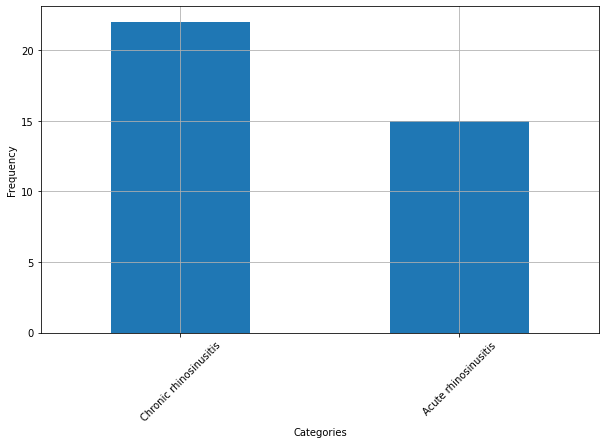

In [123]:
plt.figure(figsize=(10, 6)) 
counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Cluster 7

In [125]:
cluster_7 = extract_diagnosis_for_cluster(df, clusters, 7)
counts_7 = cluster_7.value_counts()
print(counts_7)

Unstable angina            205
Stable angina              182
Possible NSTEMI / STEMI      2
Name: PATHOLOGY, dtype: int64


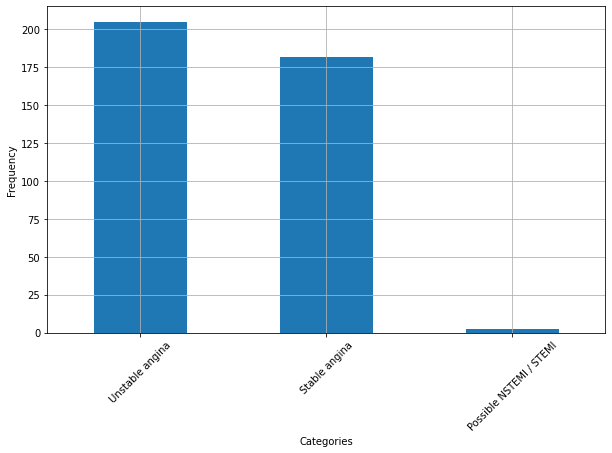

In [126]:
plt.figure(figsize=(10, 6)) 
counts_7.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Cluster 1

In [132]:
cluster_3 = extract_diagnosis_for_cluster(df, clusters, 1)
counts_3 = cluster_3.value_counts()
print(counts_3)

Bronchitis                             262
Acute otitis media                     252
Pneumonia                              231
Sarcoidosis                            206
PSVT                                   124
Pulmonary neoplasm                     115
URTI                                   113
Chagas                                  86
Pancreatic neoplasm                     84
Acute laryngitis                        79
Cluster headache                        70
Tuberculosis                            50
GERD                                    50
Spontaneous rib fracture                42
Anemia                                  38
Spontaneous pneumothorax                31
Acute COPD exacerbation / infection     30
Myocarditis                             28
Inguinal hernia                         16
Panic attack                            15
Bronchiectasis                          14
Viral pharyngitis                       13
Allergic sinusitis                      11
SLE        

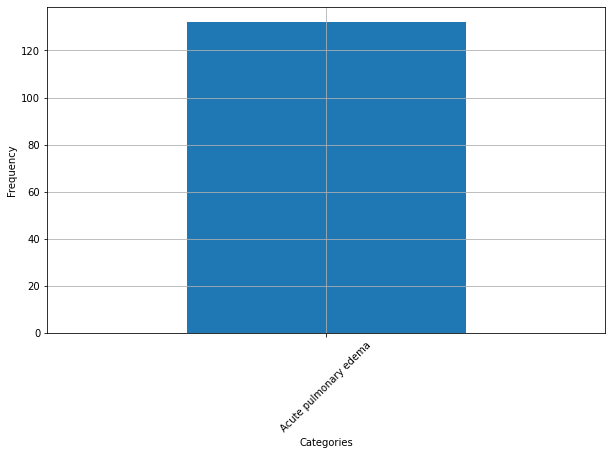

In [130]:
plt.figure(figsize=(10, 6)) 
counts_3.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()